## Workload detection algorithm

Neural network that takes as input the image of the screen and predicts the type of workload from the following categories.
* browsing
* coding
* idle
* office
* entertainment


In [21]:
# import libraries
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import os
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(
    level=0, alsologtostdout=False
)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


### Load data

Found 62 files belonging to 4 classes.
Found 1 files belonging to 4 classes.


2022-07-14 14:18:39.108706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


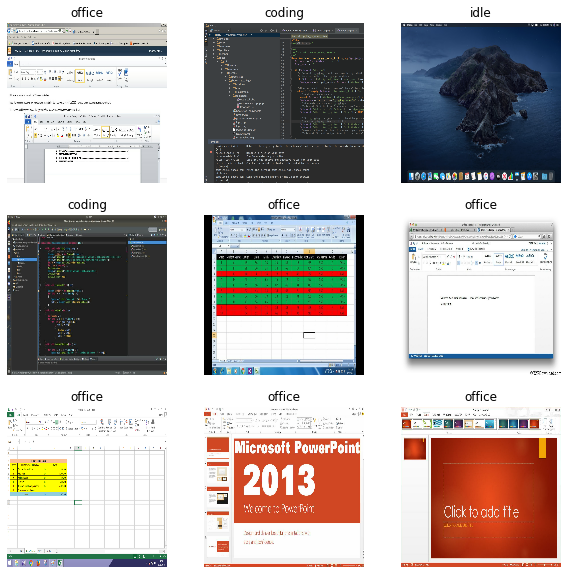

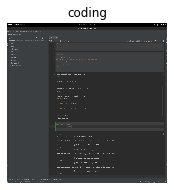

In [22]:
# paths
train_dir = 'train'
test_dir = 'test'

# Load data
BATCH_SIZE=32
IMG_SIZE= (160,160)

train_set = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_set = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

train_set.class_names
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])
# rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


### Build model

In [23]:
# base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# pooling & classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(train_set.class_names))

# full model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


# compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
len(model.layers)


8

### Train and test model

In [ ]:
history = model.fit(train_set,
                    epochs=100)

model.predict(test_set.take(1))
tf.saved_model.save(model, "models")
label_map_path = os.path.join("models", "label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(train_set.class_names):
    pbtxt_content = (
            pbtxt_content
            + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

with open('models/label_map.txt', 'w') as f:
    for i, class_name in enumerate(train_set.class_names):
        f.write(class_name + '\n')

model.evaluate(test_set)